In [2]:
from __future__ import print_function
import itertools
import math
import time

import torch
from torch import optim
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.utils as vutils
import torchvision.transforms as transforms
from IPython import display
from torch.autograd import Variable

In [3]:
nz = 100 # 노이즈 벡터의 크기
nc = 3 # 채널의 수
ngf = 128 # generator 필터 조정
ndf = 64 # discriminator 필터 조정
niter = 200 # 에폭 수
lr = 0.0002
beta1 = 0.5

imageSize = 64 # 만들어지는 이미지의 크기
batchSize = 128 # 미니배치의 크기
outf = "result"

In [4]:
transform = transforms.Compose([
        transforms.Scale(64),
        transforms.ToTensor(),                     
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = dsets.CIFAR10(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batchSize, shuffle=True)

c:\users\dglee\appdata\local\conda\conda\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Files already downloaded and verified


In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(

            # 입력값은 Z이며 Transposed Convolution을 거칩니다.
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            # (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            # (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        output = self.main(input)
        return output

In [7]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # (nc) x 64 x 64)
            nn.Conv2d(nc, ndf, 4,2,1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf * 2) x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

So=stride*(Si−1)+Sf−2∗pad # deconvolution 공식

In [8]:
netG = _netG()
netG.apply(weights_init)

netD = _netD()
netD.apply(weights_init)
criterion = nn.BCELoss()

input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
fixed_noise = Variable(fixed_noise).cuda()

#label = torch.FloatTensor(batchSize)
#labelv_fake = torch.FloatTensor(batchSize)
#print(noise.shape)
#real_label = 1
#fake_label = 0

  
netG.cuda()
netD.cuda()

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Momentum(모멘텀)

 모멘텀(momentum)이란 단어는 관성, 탄력, 가속도라는 뜻입니다. 모멘텀 SGD는 경사 하강법에 관성을 더해 주는 것입니다. 경사 하강법과 마찬가지로 매번 기울기를 구하지만, 가중치를 수정하기전 이전 수정 방향(+,-)를 참고하여 같은 방향으로 일정한 비율만 수정되게 하는 방법입니다. 수정이 양(+) 방향, 음(-) 방향 순차적으로 일어나는 지그재그 현상이 줄어들고, 이전 이동 값을 고려해여 일정 비율만큼 다음 값을 결정하므로 관성의 효과를 낼 수 있습니다.
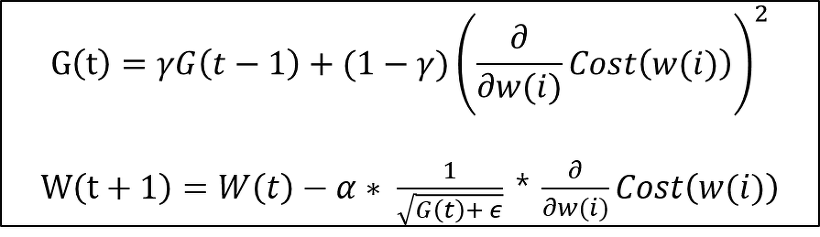
우선 아래 수식에서 α는 Learning Rate, m은 momentum 계수입니다. 
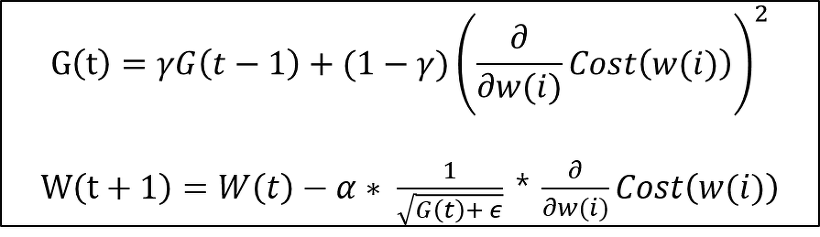
m의 정확한 용어는 아니지만 저희는 그냥 모멘텀(운동량) 또는 모멘텀 계수라고 부릅니다. 보통 0.9로 설정하며 교차 검증을 한다면 0.5에서 시작하여 0.9, 0.95, 0.99 순서로 증가시켜 검증합니다. 예시로 맨 처음 gradient()의 값이 0.5이고 두 번째 gradient 값이 -0.3이라 할 때 m이 0.9라면 V(1)은 -0.5, V(2)는 0.9 * -0.5 +0.3 = -0.45 + 0.3 = -0.15이다. 이처럼 gradient의 방향이 변경되어도 이전 방향과 크기에 영향받아 다른 방향으로 가중치가 변경될 수 있습니다.
v = m * v - learning_rate * gradient
weight[i] += v


RMSprop(알엠에스프롭)

RMSprop(알엠에스프롭)은 아다그라드의 G(t)의 값이 무한히 커지는 것을 방지하고자 제안된 방법으로, 논문과 같은 형태로 발표된 다른 방법들과 달리 제프리 힌튼 교수와 제자들이 코세라(Coursera) 수업에서 소개하였습니다. 링크를 클릭하시면 영상 페이지로 들어가실수 있으며 이론과 수식 도출에 대해 설명하고 있습니다. RMSprop은 지수 이동평균을 이용한 방법입니다. 
우선 지수 이동평균에 대해 알아보겠습니다. 지수 이동평균이란 쉽게 말해 최근 값을 더 잘 반영하기 위해 최근 값에 값과 이전 값에 각각 가중치를 주어 계산한는 방법입니다. 
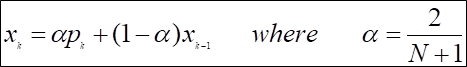
위 식에서 지수 이동편균값은 x, 현재 값은 p, 가중치는 α(알파)이며, 아래 첨자 k는 step 또는 시간, 마지막으로 N은 값의 개수라고 보시면 됩니다. 만약 처음부터 현재까지 계산을 하게 된다고 한다면 N과 k의 값은 같으며 가중치 α(알파)는 N이 작을 수록 커집니다. 
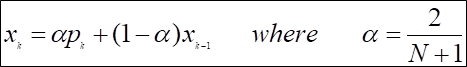
계산식을 풀어써 보면 위와 같은데 식을 보면 알 수 있듯이 1주기가 지날 때마다 (1-α)라는 가중치가 이전 값에 곱해지는데, (1-α) 값이 1보다 작기 때문에 시간이 지날수록 영향력이 줄어드는 효과를 볼 수 있습니다. 참고로 필터이론에서는 이런 가중치를 forgetting factor 또는 decaying factor라고 합니다.
RMSprop 수식은 다음과 같습니다.
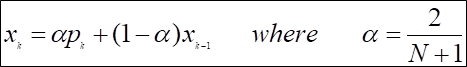
기존 Adagrad에서는 G(t)를 구성하는 두 항이 그냥 더 해지지만  RMSprop에서는 지수평균으로 더해집니다.
g = gamma * g + (1 - gamma) * gradient**2
weight[i] += -learning_rate * gradient / (np.sqrt(g) + e)

Adam(Adaptive Moment Estimation, 아담)
  Adam은 Momentum과 RMSprop를 합친? 경사 하강법입니다. RMSprop의 특징인 gradient의 제곱을 지수평균한 값을 사용하며 Momentum의 특징으로 gradient를 제곱하지 않은 값을 사용하여 지수평균을 구하고 수식에 활용합니다. 
수식은 다음과 같습니다.
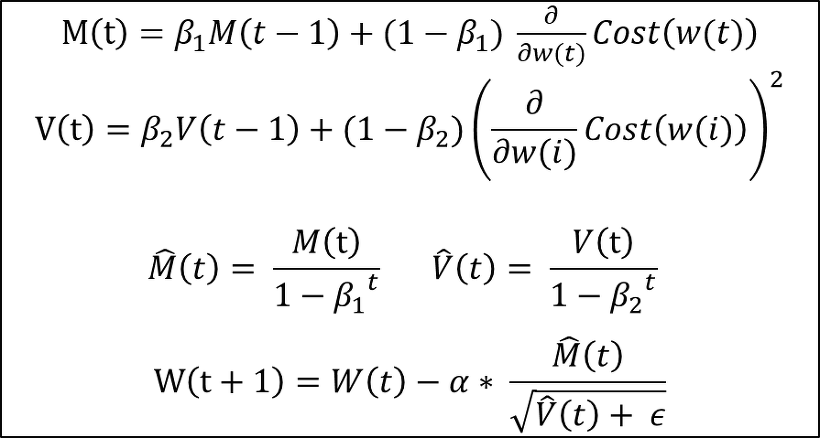
기존 RMSprop과 momentum과 다르게 M(t)와 V(t)가 바로 W(t+1) 수식에 들어가는 것이 아니라 와 가 들어갑니다. 이 부분을 논문에서는 바이어스가 수정된 값으로 변경하는 과정이라고 합니다. 이전에 저희가 알아야할 것은 초기 M(0)와 V(0)값이 0으로 초기화 되는데 시작값이 0이기 때문에 이동평균을 구하면 0으로 편향된 값추정이 발생할 수 있습니다. 특히 초기 감쇠 속도가 작은 경우 (즉, β가 1에 가까울 때)에 발생합니다. 이를 방지하기 위해 값을 나누어 바이어스 보정을 해줍니다. 은 M(t)와 V(t)의 기대값을 구하는 과정에서 찾을 수 있다고 하는데 수학적 지식이 부족하여 어떻게 발견되는지 설명드리기가 힘들 것 같습니다. 추가적으로 α=0.001, β1로는 0.9, β2로는 0.999, ϵ 으로는 10^-8 값이 가장 좋은 Default값이라고 논문에 명시되어 있습니다. 
https://arxiv.org/pdf/1412.6980.pdf

In [ ]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
epochNum = 100installed_ros_if = any(tf);
for epoch in range(epochNum):
    for i, data in enumerate(train_loader):
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)

        input.resize_as_(real_cpu).copy_(real_cpu)
        #label.resize_(batch_size).fill_(real_label)
        #labelv_fake.resize_(batch_size).fill_(fake_label)

        inputv = Variable(input).cuda()
        real_labels = Variable(torch.ones(batch_size)).cuda()
        fake_labels = Variable(torch.zeros(batch_size)).cuda()
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise).cuda()
        
        #labelv = Variable(label).cuda()
        #labelv_fake = Variable(label_fake).cuda()

        output = netD(inputv)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        #D_x = output.data.mean()

        # train with fake
       
        fake = netG(noisev)
        #labelv = Variable(label.fill_(fake_label)).cuda()
        output = netD(fake.detach())
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        #D_G_z1 = output.data.mean()

        errD = errD_real + errD_fake
        #errD.backward()
        optimizerD.step()

        netG.zero_grad()
        #labelv = Variable(label.fill_(real_label)).cuda()
        output = netD(fake)

        errG = criterion(output, real_labels)
        errG.backward()
        #D_G_z2 = output.data.mean()
        optimizerG.step()
        if ((i+1) % 100 == 0):
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,'./dcgan_result/fake_samples_epoch_%s.png' % (str(epoch)+" "+str(i+1)),normalize=True)
            vutils.save_image(real_cpu,'./dcgan_result/real_samples.png',normalize=True)
            result_dict = {"Step":i,"loss_D":errD,"loss_G":errG}
            print(result_dict)
    #do checkpointing
    torch.save(netG.state_dict(), './dcgan_result/netG.pth')
    torch.save(netD.state_dict(), './dcgan_result/netD.pth')

{'Step': 99, 'loss_G': tensor(2.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(1.0898, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor(4.3914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor(4.7049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.2662, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor(1.9598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(1.9632, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor(3.8008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor(6.2227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(3.4370, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor(

{'Step': 299, 'loss_G': tensor(4.9761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor(8.4425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(3.9613, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor(3.2580, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor(3.4589, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor(4.2161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor(4.8498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor

{'Step': 199, 'loss_G': tensor(4.3776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor(3.1213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor(0.9103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(2.3357, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor(4.1411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor(4.4931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor(2.9940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor

{'Step': 99, 'loss_G': tensor(8.7149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor(8.7781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor(9.7000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor(9.4687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 199, 'loss_G': tensor(8.9253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 299, 'loss_G': tensor(10.9730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>), 'loss_D': tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)}
{'Step': 99, 'loss_G': tensor